<a href="https://colab.research.google.com/github/sinheechan/ML/blob/main/%5BDataset%5D_%EA%B3%B5%EC%9C%A0%EC%9E%90%EC%A0%84%EA%B1%B0_%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1_0128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Dataset] 자전거 공유 수요 예측하기
  도시형 자전거 공유 시스템 활용 예측

자전거 공유 시스템은 도시 전역의 키오스크 네트워크를 통해 회원 가입, 대여, 자전거 반납 과정이 자동화되는 자전거 대여 수단입니다. 이러한 시스템을 사용하여 사람들은 한 위치에서 자전거를 빌리고 필요에 따라 다른 장소로 반납할 수 있습니다. 현재 전 세계적으로 500개가 넘는 자전거 공유 프로그램이 있습니다.

이러한 시스템에서 생성된 데이터는 여행 기간, 출발 위치, 도착 위치 및 경과 시간이 명시적으로 기록되므로 연구자에게 매력적입니다. 따라서 자전거 공유 시스템은 도시의 이동성을 연구하는 데 사용할 수 있는 센서 네트워크 역할을 합니다. 이 대회에서 참가자들은 워싱턴 DC의 Capital Bikeshare 프로그램에서 자전거 대여 수요를 예측하기 위해 과거 사용 패턴과 날씨 데이터를 결합하도록 요청받습니다.

- 평가지표

평가
제출물은 RMSLE(평균 제곱 대수 오류)로 평가됩니다. RMSLE는 다음과 같이 계산됩니다.


어디:

\\(n\\)은 테스트 세트의 시간입니다.
\\(p_i\\)는 예상 개수입니다.
\\(a_i\\)는 실제 개수입니다.
\\(\log(x)\\)는 자연  로그 입니다.

## 1. 기본 세팅
- 분석에 필요한 라이브러리들을 Import 한다.

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

# numpy 추가 설정
np.random.seed(2024)
np.set_printoptions(precision = 4, suppress = True)

# pandas 추가 설정
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
pd.options.display.max_colwidth = 80

# matplotlib 추가 설정
plt.rc("figure", figsize = (8, 4))
colors = sns.color_palette('husl')

# seaborn 추가 설정
sns.set_theme()

- 폰트 설정

In [61]:
import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt
!apt -qq install fonts-nanum
fe = fm.FontEntry(
    fname = r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name = 'NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 12, 'font.family': 'NanumGothic'})

fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


## 2. 데이터 불러오기

[요약]
- 자료는 train.csv 와 test.csv 두 개의 데이터 셋이 제공된다.

In [62]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv("/content/test.csv")

print(len(train))
print(len(test))

10886
6493


[데이터]

datetime - hourly date + timestamp (날짜와 시간)

season - 1 = spring, 2 = summer, 3 = fall, 4 = winter (계절)

holiday - whether the day is considered a holiday (휴일)

workingday - whether the day is neither a weekend nor holiday (평일)

weather -
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy (맑은 날씨)

  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist (안개)

  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds (가벼운 눈, 비)

  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog (폭설, 폭우)

temp - temperature in Celsius (온도)

atemp - “feels like” temperature in Celsius (체감 온도)

humidity - relative humidity (상대 습도)

windspeed - wind speed (풍속)

casual - number of non-registered user rentals initiated (비회원 대여량)

registered - number of registered user rentals initiated (회원 대여량)

count - number of total rentals (총 대여량)



## 3. EDA

In [63]:
print(train.shape)
print("-"*100)
print(test.shape)

(10886, 12)
----------------------------------------------------------------------------------------------------
(6493, 9)


In [64]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [65]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [66]:
print(train.info())
print("-"*100)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  

[요약]
- train : 총 12개의 칼럼
- test : 총 9개의 칼럼이며 casual, registered, count 칼럼이 없다.

- train, test 데이터 셋 모두 결측치가 없는 것으로 확인된다.

## 4. 데이터 시각화

### 4.1 시계열 데이터 가공

- 'datetime' 칼럼은 시계열 정보를 나타내므로 Dtype을 datetime으로 변경한다.
- 'datetime' 칼럼에서 세부 날짜별 정보를 보기 위해 데이터를 년,월,일, 시간으로 분리한다.

In [67]:
# 'datetime' 칼럼 Dtype 변경
train['datetime'] = train.datetime.apply(pd.to_datetime)

# datetime 칼럼의 year, month, day, hour 기준 세분화 및 새로운 Feature 생성
train['year'] = train.datetime.apply(lambda x : x.year)
train['month'] = train.datetime.apply(lambda x : x.month)
train['day'] = train.datetime.apply(lambda x : x.day)
train['hour'] = train.datetime.apply(lambda x: x.hour)

In [68]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


### 4.2 데이터 시각화

[칼럼 분리]

- 현재 주어진 칼럼을 특성에 따라 총 5개의 분류로 나눠 분석한다.

  - 계절날씨 : 'season' 'weather'
  - 기온,기후 : 'temp', 'atemp', 'humidity', 'windspeed'
  - 인구통계 : 'holiday' 'workingday'
  - 시간 : 'year', 'month', 'day', 'hour'



#### 4.2.1 계절날씨 그룹 시각화


- 'season' 'weather' 변수 시각화한다.

<ipython-input-69-1aa1e5a8c7fe>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)
<ipython-input-69-1aa1e5a8c7fe>:5: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.pointplot(data=train, x='month', y='count', hue='season', palette=colors)
<ipython-input-69-1aa1e5a8c7fe>:9: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.pointplot(data=train, x='hour', y='count', hue='weather', palette=colors)


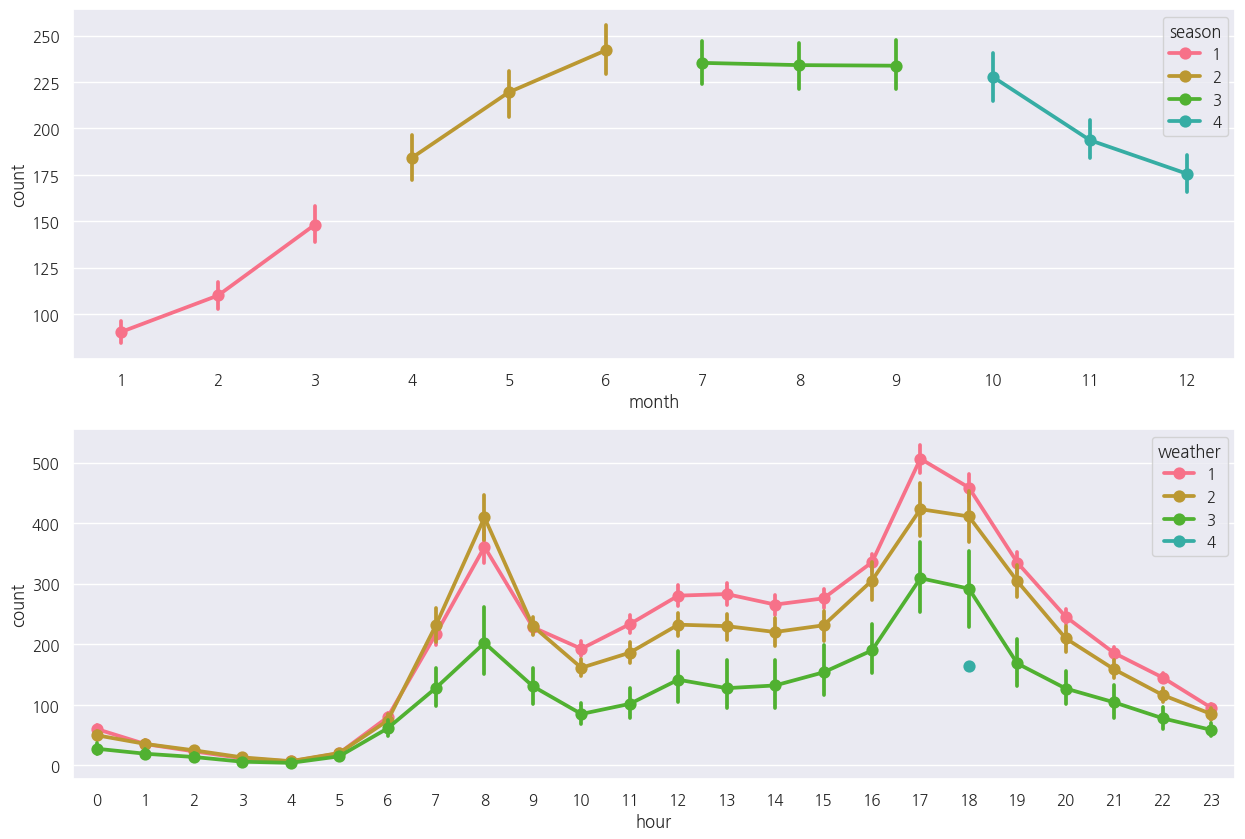

In [69]:
plt.subplots(figsize=(15,10))

# 1. season 그래프
plt.subplot(2, 1, 1)
sns.pointplot(data=train, x='month', y='count', hue='season', palette=colors)

# 2. weather 그래프
plt.subplot(2, 1, 2)
sns.pointplot(data=train, x='hour', y='count', hue='weather', palette=colors)

plt.show()

[요약]
- season : 1~3월에 사용량이 급격히 낮음을 확인할 수 있다. 아마 워싱턴지역의 특성상 해당 월에 기온이 낮아 사용량이 또한 낮은 것으로 추측된다.
- weather : 맑음(1), 약간 흐림(2)에서는 차이가 없으나 약간 비옴(3)에서 사용량이 낮아지고 폭우(4)에서는 사용량이 거의 없다.

#### 4.2.2 기온,기후 그룹 시각화

-  'temp', 'atemp', 'humidity', 'windspeed' 변수 시각화

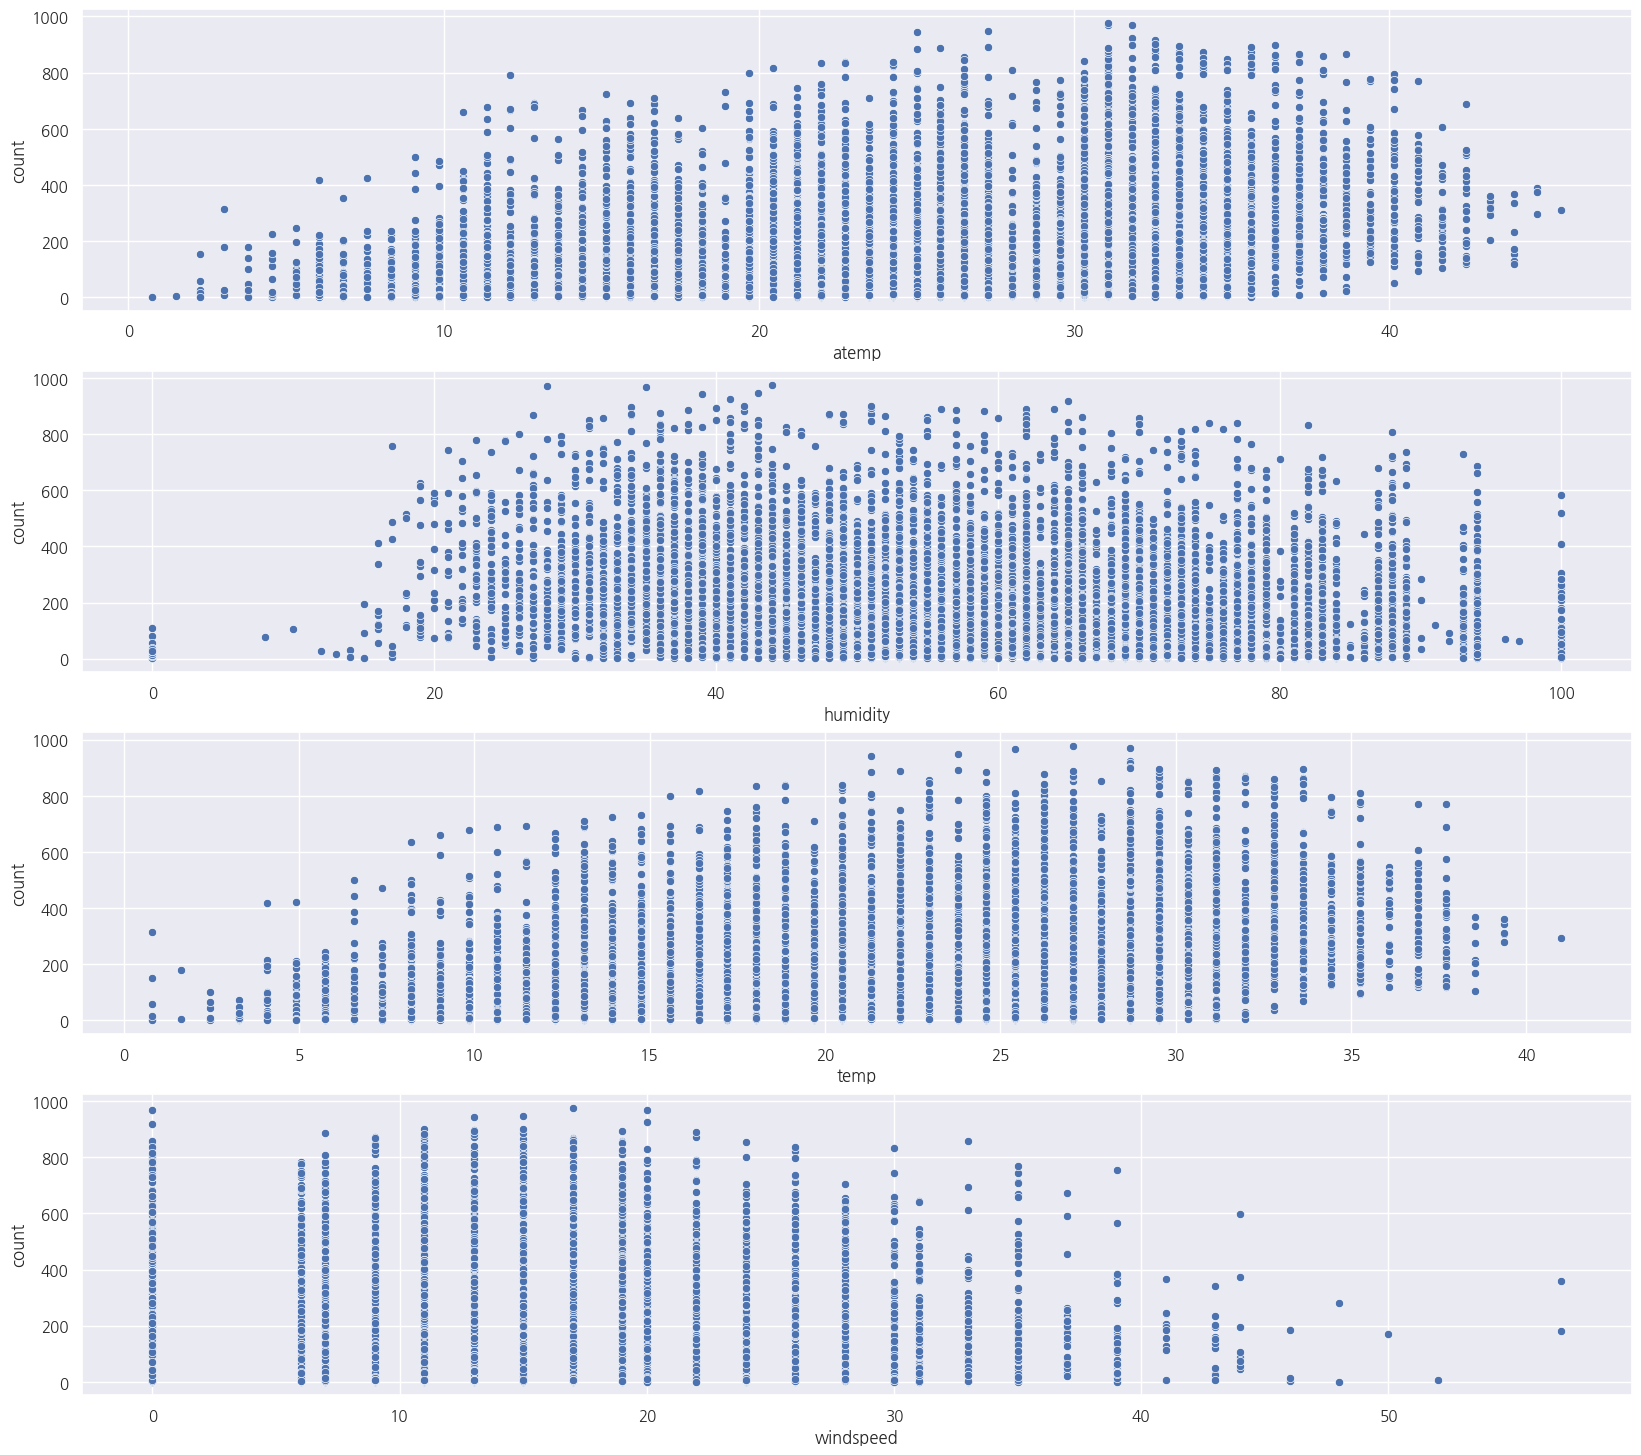

In [70]:
plt.figure(figsize=(20, 18))

# 1. atemp 그래프
plt.subplot(4, 1, 1)
sns.scatterplot(data = train, x = 'atemp', y = 'count')

# 2. humidity 그래프
plt.subplot(4, 1, 2)
sns.scatterplot(data = train, x = 'humidity', y = 'count')

# 3. temp 그래프
plt.subplot(4, 1, 3)
sns.scatterplot(data = train, x = 'temp', y = 'count')

# 4. windspeed 그래프
plt.subplot(4, 1, 4)
sns.scatterplot(data = train, x = 'windspeed', y = 'count')

plt.show()

[요약]
- atemp : 체감온도가 낮을 때는 사용량이 적고 나머지는 사용량이 비슷하다.
- humidity : 습도가 아주 낮을 때는 사용량이 적고 나머지는 사용량이 비슷하다.
- temp : 온도가 아주 낮을 때는 사용량이 적고 나머지는 사용량이 비슷하다.
- windspeed : 바람의 세기가 강해질수록 사용량이 줄어든다.

### 5.3 인구통계 그룹 시각화

- 'holiday' 'workingday' 변수 시각화

<ipython-input-71-4b49ea80485f>:5: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.pointplot(data = train, x = 'hour', y = 'count', hue = 'workingday', palette = colors)
<ipython-input-71-4b49ea80485f>:9: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.pointplot(data = train, x = 'hour', y = 'count', hue = 'holiday', palette = colors)


<Axes: xlabel='hour', ylabel='count'>

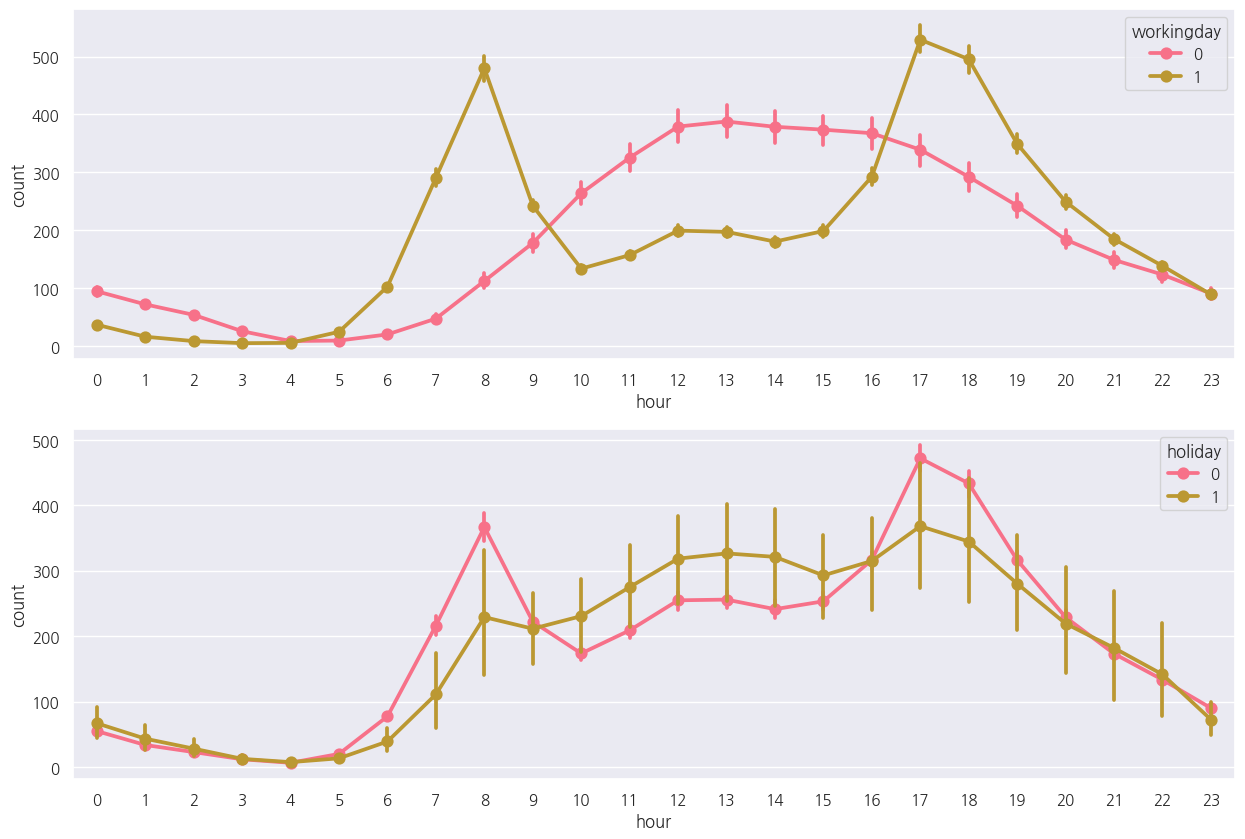

In [71]:
plt.figure(figsize = (15, 10))

# 1. workingday 그래프
plt.subplot(2,1,1)
sns.pointplot(data = train, x = 'hour', y = 'count', hue = 'workingday', palette = colors)

# 2. holiday 그래프
plt.subplot(2,1,2)
sns.pointplot(data = train, x = 'hour', y = 'count', hue = 'holiday', palette = colors)

[요약]
- holiday 와 workingday는 사용 시간대의 차이가 존재할 뿐 사용량에는 유의미한 차이는 보이지 않는다.

### 5.4 시간 그룹 시각화

-  'year', 'month', 'day', 'hour' 변수 시각화

<ipython-input-72-e79209aea876>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = train, x = 'year', y = 'count', palette = colors)
<ipython-input-72-e79209aea876>:5: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.barplot(data = train, x = 'year', y = 'count', palette = colors)
<ipython-input-72-e79209aea876>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = train, x = 'month', y = 'count',palette = colors)
<ipython-input-72-e79209aea876>:9: UserWarning: 
The palette list has fewer values (6) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data = train, x = 'month', y = 'count',palett

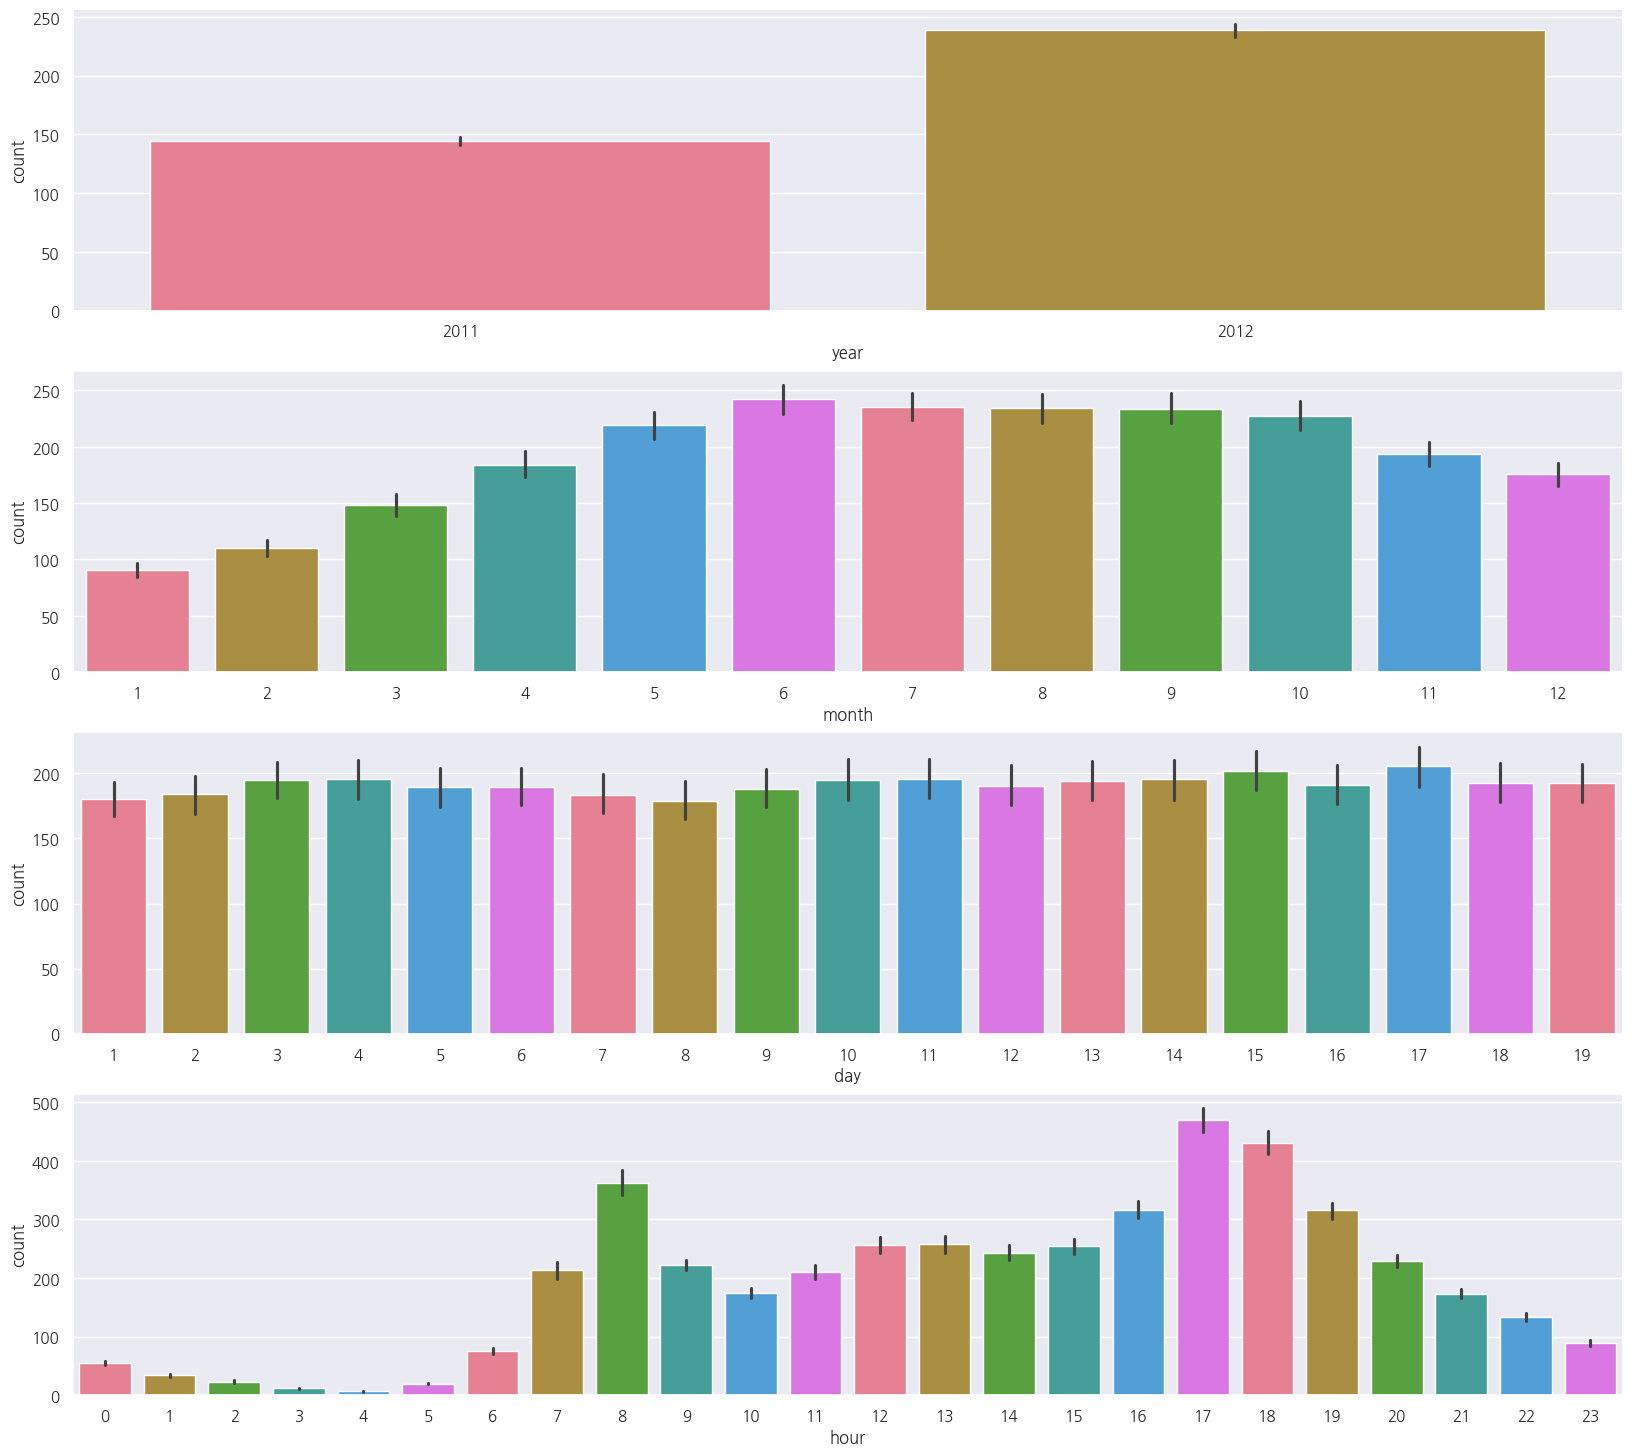

In [72]:
plt.figure(figsize=(20, 18))

# 1. year 그래프
plt.subplot(4, 1, 1)
sns.barplot(data = train, x = 'year', y = 'count', palette = colors)

# 2. month 그래프
plt.subplot(4, 1, 2)
sns.barplot(data = train, x = 'month', y = 'count',palette = colors)

# 3. day 그래프
plt.subplot(4, 1, 3)
sns.barplot(data = train, x = 'day', y = 'count',palette = colors)

# 4. hour 그래프
plt.subplot(4, 1, 4)
sns.barplot(data = train, x = 'hour', y = 'count',palette = colors)

plt.show()


[요약]
- year : 작년 대비 공유 자전거 대여 수가 약 60% 증가하였다.
- month : 1~3월에는 사용량이 낮으나 나머지 달에서는 비슷한 사용량을 보인다.
- day : 일별 그래프에서는 특별한 점을 찾지 못했다.
- hour : 8시, 17~19 시에 사용량이 많다. 출근, 퇴근 시간에 영향을 받는 것으로 판단된다.

[시각화 요약]

- 전반적인 데이터 시각화 및 분석 결과, 날씨가 추운 1~3월에 사용량이 가장 낮으며 나머지 계절은 비슷한 사용량을 보였다.
- 따라서 공유자전거 대여에 가장 큰 영향을 주는 것은 날씨 및 기후인 것으로 사료된다.

## 6. Feature Engineering

### 6.1 변수간 상관관계 시각화

- 변수 별 상관관계 분석 후 위 시각화 그래프와 대조하여 분석에 유의미한 변수를 선별한다.

In [73]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


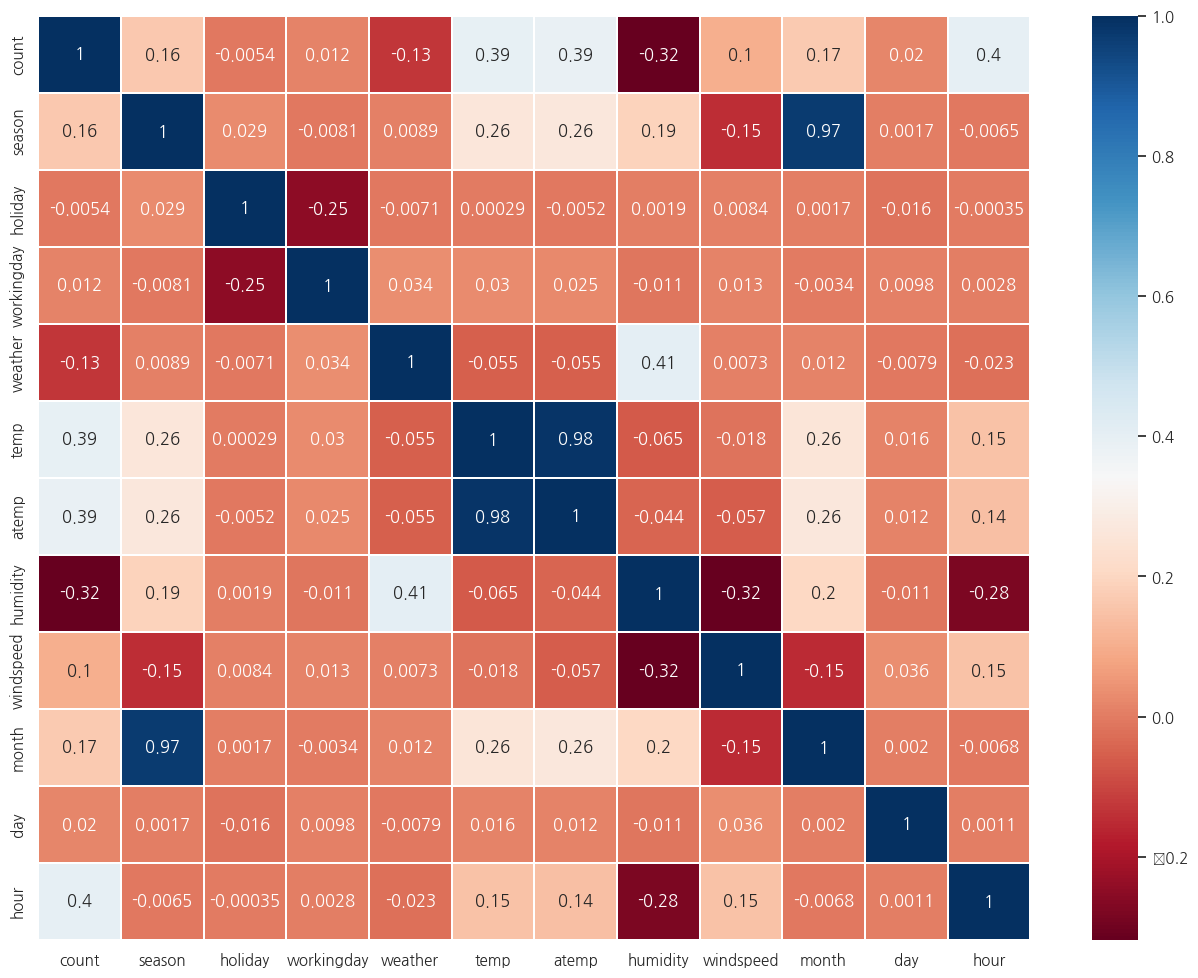

In [74]:
plt.subplots(figsize=(16,12))

corr_train = train[['count', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'month', 'day', 'hour']].corr()
sns.heatmap(data=corr_train, linewidths=0.1, linecolor='white', annot=True, cmap=plt.cm.RdBu)



[요약]
- 'month' 와 'season' 에서 상관관계가 아주 높게 도출되었다. (0.97)
- 'temp' 와 'atemp' 에서 상관관계가 아주 높게 도출되었다. (0.98)
- 따라서 'month' 와 'season'은 타 변수 분석에 필요한 지표이므로 유지하되 'temp' 와 'atemp'은 동일 변수로 취급한다.


## 7. 데이터 전처리

### 7.2 이상치 제거

- 모든 연속형 변수들의 boxplot을 시각화한다.

<Axes: xlabel='count'>

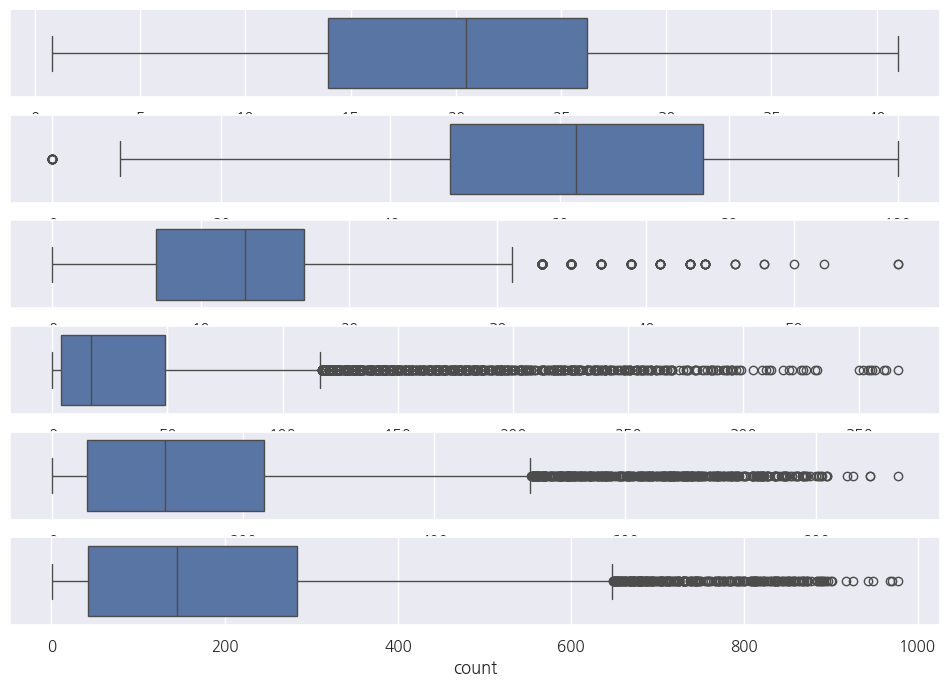

In [75]:
fig, axes = plt.subplots(6, 1, figsize = (12, 8))

sns.boxplot(data = train, x="temp", ax=axes[0])
sns.boxplot(data = train, x="humidity", ax=axes[1])
sns.boxplot(data = train, x="windspeed", ax=axes[2])
sns.boxplot(data = train, x="casual", ax=axes[3])
sns.boxplot(data = train, x="registered", ax=axes[4])
sns.boxplot(data = train, x="count", ax=axes[5])

- windspeed, count에 이상치가 존재하는 것을 확인할 수 있다.
- 따라서 이상치를 제거하는 작업을 수행한다.

(10212, 16)


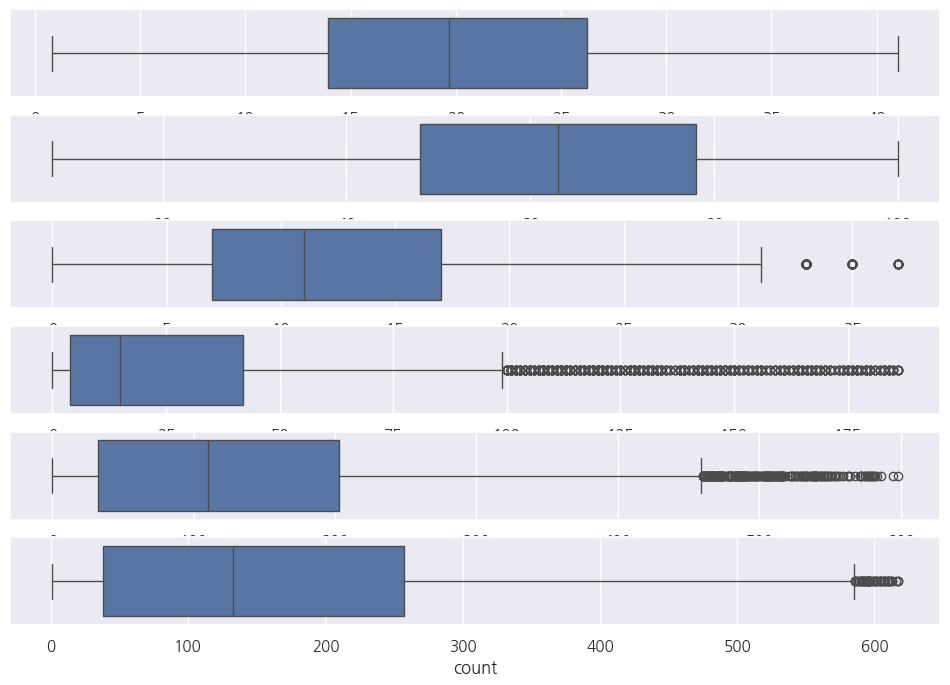

In [76]:
# 이상치 제거
cols = ['humidity', 'windspeed', 'casual', 'registered', 'count']
for col in cols:
    train = train[np.abs(train[col] - train[col].mean()) <= (3*train[col].std())]

fig, axes = plt.subplots(6, 1, figsize = (12, 8))

sns.boxplot(data = train, x="temp", ax=axes[0])
sns.boxplot(data = train, x="humidity", ax=axes[1])
sns.boxplot(data = train, x="windspeed", ax=axes[2])
sns.boxplot(data = train, x="casual", ax=axes[3])
sns.boxplot(data = train, x="registered", ax=axes[4])
sns.boxplot(data = train, x="count", ax=axes[5])

print(train.shape)  #(10886, 12) 변경 전 => (10212, 20) 변경 후

- 모든 변수의 이상치 제거를 확인하였다.

### 7.3 정규화

- count 값의 boxplot 분포를 확인해보면 0에 몰려있는 형태를 띄어 로그를 씌워 정규화를 해준다.

<ipython-input-77-780d073af7e8>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['count'], ax=axes[0][0])
<ipython-input-77-780d073af7e8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(train['count']), ax=axes[1][0])


((array([-3.8158, -3.5909, -3.4675, ...,  3.4675,  3.5909,  3.8158]),
  array([0.6931, 0.6931, 0.6931, ..., 6.4249, 6.4265, 6.4265])),
 (1.3220933643512593, 4.487988202781829, 0.9548709365821001))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


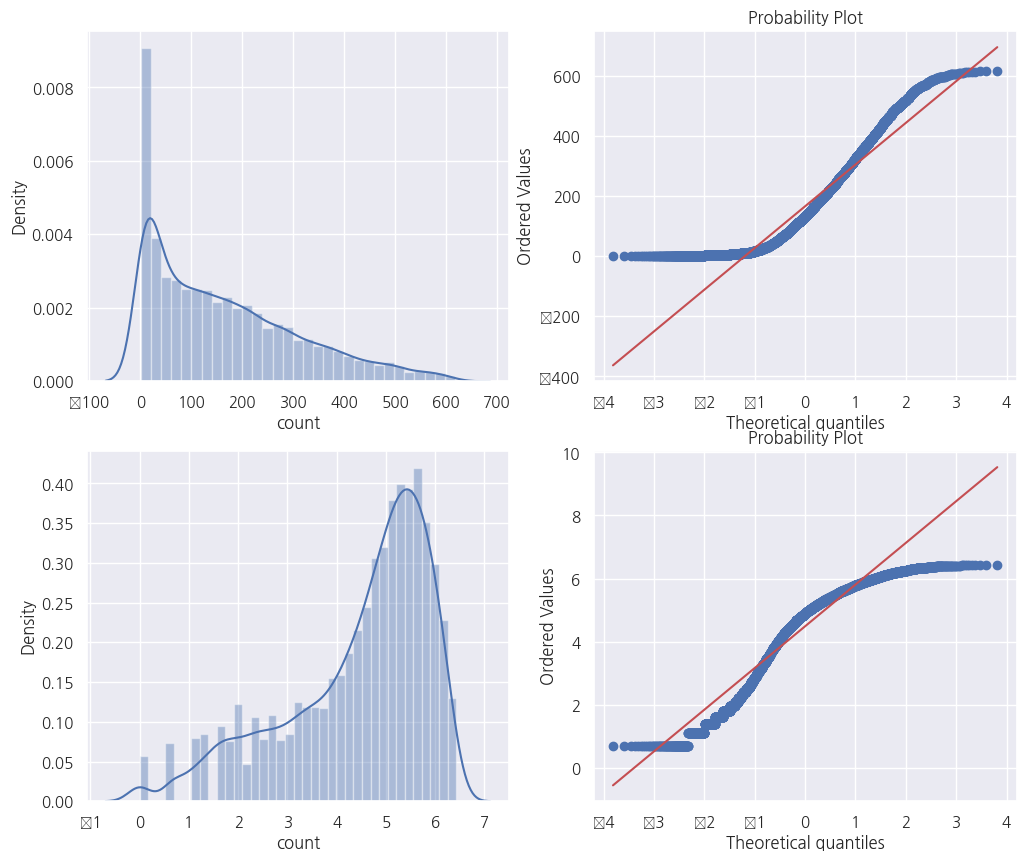

In [77]:
# count 값의 데이터 분포 파악
figure, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.distplot(train['count'], ax=axes[0][0])

stats.probplot(train['count'], dist='norm', fit=True, plot=axes[0][1])

sns.distplot(np.log(train['count']), ax=axes[1][0])

stats.probplot(np.log1p(train['count']), dist='norm', fit=True, plot=axes[1][1])

- 위 log 씌운 count 값을 새로운 칼럼 'count_log'으로 생성한다.

In [78]:
train['count_log'] = train['count'].map(lambda i:np.log(i) if i > 0 else 0)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,count_log
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,2.772589
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,3.688879
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,3.465736
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,2.564949
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0.000000


### 7.3 범주형 변수 변경

- 범주형인 변수들을 category 형태로 바꿔준다.

In [79]:
cols = ['season', 'holiday', 'workingday', 'weather', 'month', 'year']

for col in cols:
    train[col] = train[col].astype('category')

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10212 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10212 non-null  datetime64[ns]
 1   season      10212 non-null  category      
 2   holiday     10212 non-null  category      
 3   workingday  10212 non-null  category      
 4   weather     10212 non-null  category      
 5   temp        10212 non-null  float64       
 6   atemp       10212 non-null  float64       
 7   humidity    10212 non-null  int64         
 8   windspeed   10212 non-null  float64       
 9   casual      10212 non-null  int64         
 10  registered  10212 non-null  int64         
 11  count       10212 non-null  int64         
 12  year        10212 non-null  category      
 13  month       10212 non-null  category      
 14  day         10212 non-null  int64         
 15  hour        10212 non-null  int64         
 16  count_log   10212 non-

### 7.4 test set 전처리


- 위에서 train 데이터셋 가공한 자료를 함수화해주어 test 셋에도 적용해준다.

In [80]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,count_log
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,2.772589
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,3.688879
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,3.465736
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,2.564949
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0.000000


In [81]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [82]:
# Datetume 데이터 나누기
def datetime_divide(df):
    df['datetime'] = df['datetime'].apply(pd.to_datetime)

    df['year'] = df['datetime'].apply(lambda x: x.year)
    df['month'] = df['datetime'].apply(lambda x: x.month)
    df['day'] = df['datetime'].apply(lambda x: x.day)
    df['hour'] = df['datetime'].apply(lambda x: x.hour)

    return df

# 이상치 제거
def outliers_remove(df, cols):
  cols = ['humidity', 'windspeed']
  for col in cols:
      df = df[np.abs(df[col] - df[col].mean()) <= (3 * df[col].std())]

  return df

# 로그처리
def log_count(df):
  df['count_log'] = df['count'].map(lambda i:np.log(i) if i > 0 else 0)

# 범주형 변수 변경
def dtype_category(df, cols):
  for col in cols:
      df[col] = df[col].astype('category')

  return df

# train 데이터셋 가공 함수
def transform_features_train(df):
    df = datetime_divide(df)
    df = outliers_remove(df, ['humidity', 'windspeed', 'casual', 'registered', 'count'])
    log_count(df)
    df = dtype_category(df, ['season', 'holiday', 'workingday', 'weather', 'month', 'year'])

    return df

# test 데이터셋 가공 함수
def transform_features_test(df):
    df = datetime_divide(df)
    df = outliers_remove(df, ['humidity', 'windspeed'])
    df = dtype_category(df, ['season', 'holiday', 'workingday', 'weather', 'month', 'year'])

    return df

In [83]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

train_df = transform_features_train(train)
test_df = transform_features_test(test)

## 8. Modeling

### 8.1 변수 선택

- 먼저 피쳐로 사용할 변수를 리스트로 만들어준 뒤 train_input, train_target, test_input을 만들어준다.
  - train 데이터셋과 test 데이터셋의 칼럼을 일치시킨 후 각각 train_input, test_input에 저장한다.
  - target : 기존 'count'가 아닌 위에서 만들었던 'count_log'를 사용할 것이다

1) train_input 가공

In [84]:
features = ['season', 'holiday', 'weather', 'temp', 'humidity','windspeed', 'year', 'month', 'hour']

train_input = train_df[features]

print(train_input.shape)
train_input.head()

(10798, 9)


,season,holiday,weather,temp,humidity,windspeed,year,month,hour
0,1,0,1,9.84,81,0.0,2011,1,0
1,1,0,1,9.02,80,0.0,2011,1,1
2,1,0,1,9.02,80,0.0,2011,1,2
3,1,0,1,9.84,75,0.0,2011,1,3
4,1,0,1,9.84,75,0.0,2011,1,4


2) test_input 가공

In [85]:
test_input = test[features]

print(test_input.shape)
test_input.head()

(6493, 9)


,season,holiday,weather,temp,humidity,windspeed,year,month,hour
0,1,0,1,10.66,56,26.0027,2011,1,0
1,1,0,1,10.66,56,0.0000,2011,1,1
2,1,0,1,10.66,56,0.0000,2011,1,2
3,1,0,1,10.66,56,11.0014,2011,1,3
4,1,0,1,10.66,56,11.0014,2011,1,4


3) train 데이터셋의 log_count 데이터로 target 가공

In [87]:
train_target = train_df['count_log']

print(train_target.shape)
train_target.head()

(10798,)


0    2.772589
1    3.688879
2    3.465736
3    2.564949
4    0.000000
Name: count_log, dtype: float64

### 8.2 RMSLE & 모델 학습

- 자전거의 일별 대여량을 예측하는 문제이므로 회귀(Regression) 모델을 사용할 것이다
- 본 분석은 회귀 평가 지표중 하나인 RMSLE(Root Mean Squared Logarithmic Error) Score 로 평가한다.

1) RMSLE 함수 생성

In [91]:
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))

    return rmsle

rmsle_score = make_scorer(rmsle)

2) kfold 교차 검증과 GradientBoostingRegressor 모델로 학습을 진행한다.

In [92]:
# KFold
kfold = KFold(n_splits=10, random_state=42, shuffle=True)

from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=42)
scores = cross_validate(model, train_input, train_target,
                       return_train_score=True, n_jobs=-1)

# train, val data 점수
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

# RMSLE 점수
score = cross_val_score(model, train_input, train_target, cv=kfold, scoring=rmsle_score)
score = score.mean()

print(score)

model.fit(train_input, train_target)

0.8439483569828052 0.7919494320114702
0.16871867812596214


GradientBoostingRegressor(random_state=42)

## 9. 예측 및 제출

- 이제 test_input에 대해 예측을 해주고 submission 데이터를 만든뒤 제출한다.

1) 예측하기

In [94]:
pred = model.predict(test_input)

2) submission 제출 파일에 데이터 저장

In [95]:
submission = pd.read_csv("/content/sampleSubmission.csv")
submission['count_log'] = pred

# count_log를 다시 count로 바꾸기
submission['count'] = np.exp(submission['count_log'])
submission.drop('count_log', axis=1, inplace=True)
submission.head()

,datetime,count
0,2011-01-20 00:00:00,12.644722
1,2011-01-20 01:00:00,9.164534
2,2011-01-20 02:00:00,5.223980
3,2011-01-20 03:00:00,3.149372
4,2011-01-20 04:00:00,2.303332


3) 로컬 환경에 csv 파일 저장

In [97]:
submission.to_csv("/content/sampleSubmission_True.csv", index=False)